### Delete the patches

In [22]:
import os

# Define the folders to clean
folders_to_clean = [
    "../data/patches/images",  
    "../data/patches/masks" 
]

# Iterate over each folder
for folder_path in folders_to_clean:
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue

    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file has a .jpg extension (case-insensitive)
        if file_name.lower().endswith(".png"):
            # Create the full file path
            file_path = os.path.join(folder_path, file_name)
            
            # Remove the file
            os.remove(file_path)
            print(f"Deleted: {file_path}")

print("All .jpg files have been deleted from specified folders.")

Deleted: ../data/patches/images/patch_img_5.png
Deleted: ../data/patches/images/patch_img_4.png
Deleted: ../data/patches/images/patch_img_6.png
Deleted: ../data/patches/images/patch_img_7.png
Deleted: ../data/patches/images/patch_img_3.png
Deleted: ../data/patches/images/patch_img_2.png
Deleted: ../data/patches/images/patch_img_0.png
Deleted: ../data/patches/images/patch_img_1.png
Deleted: ../data/patches/images/patch_img_14.png
Deleted: ../data/patches/images/patch_img_15.png
Deleted: ../data/patches/images/patch_img_17.png
Deleted: ../data/patches/images/patch_img_16.png
Deleted: ../data/patches/images/patch_img_12.png
Deleted: ../data/patches/images/patch_img_13.png
Deleted: ../data/patches/images/patch_img_11.png
Deleted: ../data/patches/images/patch_img_10.png
Deleted: ../data/patches/images/patch_img_21.png
Deleted: ../data/patches/images/patch_img_20.png
Deleted: ../data/patches/images/patch_img_22.png
Deleted: ../data/patches/images/patch_img_23.png
Deleted: ../data/patches/ima

### Create the patches from the refined folder into 256x256 patches.

Loading SAM model on device: cpu

--- Processing FNE_100_158.jpg ---
Image path: ../data/refined/img-stones/FNE_100_158.jpg
Image size: 663 x 524
  Number of auto masks: 98


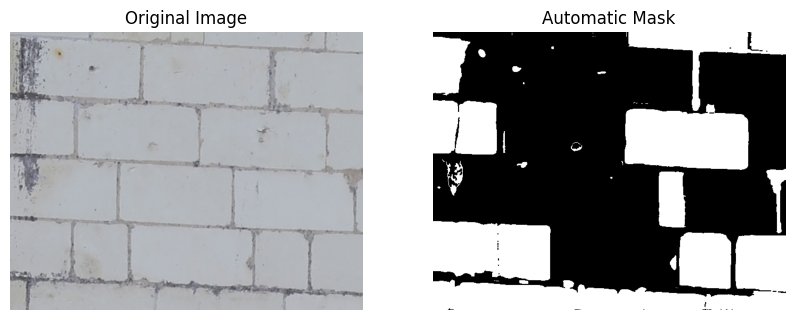

Python(8984) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-03-04 17:49:21.934 Python[8984:2408889] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-04 17:49:21.934 Python[8984:2408889] +[IMKInputSession subclass]: chose IMKInputSession_Modern


New box: (7, 235, 202, 359)
New box: (120, 129, 352, 252)
New box: (248, 29, 488, 155)
New box: (227, 362, 457, 489)
New box: (22, 9, 243, 131)
New box: (491, 32, 657, 148)
New box: (419, 262, 648, 376)
New box: (203, 251, 417, 362)
New box: (462, 373, 571, 385)
New box: (571, 383, 655, 493)
New box: (454, 378, 564, 485)
All boxes: [(7, 235, 202, 359), (120, 129, 352, 252), (248, 29, 488, 155), (227, 362, 457, 489), (22, 9, 243, 131), (491, 32, 657, 148), (419, 262, 648, 376), (203, 251, 417, 362), (462, 373, 571, 385), (571, 383, 655, 493), (454, 378, 564, 485)]
Saved bounding boxes to temp_boxes.json
  Non-zero pixels in final mask: 293510
  -> Patches saved from FNE_100_158.jpg: 35

--- Processing FSE_35_008.jpg ---
Image path: ../data/refined/img-stones/FSE_35_008.jpg
Image size: 473 x 398


KeyboardInterrupt: 

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import subprocess
import json

# -------------------------------------------------------------
# 1) Environment Setup
# -------------------------------------------------------------
# Add the path to the Segment Anything library
sys.path.append("../third_party/segment-anything/")

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# -------------------------------------------------------------
# 2) Load or Initialize Annotations from JSON
#    (Using the file: ../data/annotations/boxe.json)
# -------------------------------------------------------------
annotations_path = "../data/annotations/boxe.json"
if os.path.exists(annotations_path):
    with open(annotations_path, "r") as f:
        boxes_dict = json.load(f)
else:
    boxes_dict = {}  # Start with an empty dictionary if no file exists

# -------------------------------------------------------------
# 2.1) Define path to create-boxes.py
#      Update this path as needed
# -------------------------------------------------------------
create_boxes_script = "../scripts/create-boxes.py" 

# -------------------------------------------------------------
# 3) Define build_totalmask() function
# -------------------------------------------------------------
def build_totalmask(pred) -> np.ndarray:
    """
    Builds a binary mask from SAM predictions.
    Stones = white (255), mortar = black (0).
    Fills small holes using morphological closing.
    
    Input:
      - pred: list of dicts (output of SAM segmentation)
    Output:
      - Binary mask (np.uint8) or None if no masks generated.
    """
    if len(pred) == 0:
        return None

    height, width = pred[0]['segmentation'].shape
    total_mask = np.zeros((height, width), dtype=np.uint8)

    for seg in pred:
        seg_bin = seg['segmentation'].astype(np.uint8)
        total_mask += seg_bin

    _, total_mask_bin = cv2.threshold(total_mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    kernel = np.ones((2, 2), np.uint8)
    total_mask_bin = cv2.morphologyEx(total_mask_bin, cv2.MORPH_CLOSE, kernel)

    return total_mask_bin

# -------------------------------------------------------------
# 4) Load the SAM Model and Create Generators/Predictors
# -------------------------------------------------------------
sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"  # Change to "cuda" if you have a GPU

print("Loading SAM model on device:", device)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,             # Increase to detect smaller stones
    pred_iou_thresh=0.86,            # Slightly relaxed mask accuracy
    stability_score_thresh=0.92,    # Slightly relaxed stability for more masks
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100         # Lowered to bring back smaller stones
)

mask_predictor = SamPredictor(sam)

# -------------------------------------------------------------
# 5) Process Images in the Refined Folder and Extract Patches
# -------------------------------------------------------------
refined_folder = "../data/refined/img-stones"  
output_dir_img = "../data/patches/images"
output_dir_mask = "../data/patches/masks"
os.makedirs(output_dir_img, exist_ok=True)
os.makedirs(output_dir_mask, exist_ok=True)

patch_size = 256  # 256x256 patches
stride = 64       # 64 pixel stride
stone_threshold = 0.1  # At least 10% of the patch must be stone

# Loop over all image files in the refined folder
image_files = [
    f for f in os.listdir(refined_folder)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

patch_count = 0

for img_file in image_files:
    img_path = os.path.join(refined_folder, img_file)
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        print(f"Skipping {img_file} -> Unable to load image.")
        continue

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    height, width, _ = image_rgb.shape
    print(f"\n--- Processing {img_file} ---")
    print(f"Image path: {img_path}")
    print(f"Image size: {width} x {height}")

    # 5A) Generate Automatic Masks with SAM
    masks_auto = mask_generator.generate(image_rgb)
    print(f"  Number of auto masks: {len(masks_auto)}")
    if len(masks_auto) == 0:
        print("  No auto masks found; skipping.")
        continue

    auto_mask_bin = build_totalmask(masks_auto)
    if auto_mask_bin is None:
        print("  auto_mask_bin is None; skipping.")
        continue

    # 5B) Display the image and its auto mask for inspection
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(auto_mask_bin, cmap="gray")
    plt.title("Automatic Mask")
    plt.axis("off")
    plt.show()

    # 5C) Check if annotation for missing stones exists in the JSON.
    if img_file not in boxes_dict:
        user_response = input(f"Annotation for {img_file} not found. Do you want to annotate missing stones? (y/n): ")
        if user_response.lower().startswith("y"):
            # Call create-boxes.py with the image path.
            subprocess.run(["python", create_boxes_script, img_path])
            
            # After create-boxes.py finishes, check for temp_boxes.json
            if os.path.exists("temp_boxes.json"):
                with open("temp_boxes.json", "r") as f:
                    manual_boxes = json.load(f)
                # Update the boxes_dict for the current image
                boxes_dict[img_file] = manual_boxes
                # Save the updated boxes_dict to the annotations file
                with open(annotations_path, "w") as f:
                    json.dump(boxes_dict, f, indent=2)
                # Remove the temporary file
                os.remove("temp_boxes.json")
            else:
                print("Annotation file not updated; proceeding without manual boxes.")

    # 5D) If the JSON now has boxes for this image, refine the mask.
    if img_file in boxes_dict:
        manual_boxes = boxes_dict[img_file]
        if len(manual_boxes) > 0:
            mask_predictor.set_image(image_rgb)
            input_boxes = torch.tensor(manual_boxes, device=mask_predictor.device)
            transformed_boxes = mask_predictor.transform.apply_boxes_torch(
                input_boxes, image_rgb.shape[:2]
            )
            masks_box, scores, logits = mask_predictor.predict_torch(
                point_coords=None,
                point_labels=None,
                boxes=transformed_boxes,
                multimask_output=False
            )
            masks_box = masks_box.squeeze(1).cpu().numpy()  # (num_boxes, H, W)
            combined_mask_bool = auto_mask_bin.astype(bool)
            for i in range(masks_box.shape[0]):
                stone_bool = masks_box[i].astype(bool)
                combined_mask_bool = np.logical_or(combined_mask_bool, stone_bool)
            final_mask_bin = (combined_mask_bool.astype(np.uint8) * 255)
        else:
            final_mask_bin = auto_mask_bin
    else:
        final_mask_bin = auto_mask_bin

    # 5E) Verify that the final mask contains stone areas.
    nz_count = cv2.countNonZero(final_mask_bin)
    print(f"  Non-zero pixels in final mask: {nz_count}")
    if nz_count == 0:
        print("  Final mask is all black; skipping.")
        continue

    # 5F) Extract 256x256 patches from the final mask and original image.
    if height < patch_size or width < patch_size:
        print(f"  {img_file} is too small for {patch_size}x{patch_size} patches; skipping.")
        continue

    local_patch_count = 0
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch_mask = final_mask_bin[y:y+patch_size, x:x+patch_size]
            patch_img = image_rgb[y:y+patch_size, x:x+patch_size]

            stone_pixels = cv2.countNonZero(patch_mask)
            total_pixels = patch_size * patch_size
            if stone_pixels > stone_threshold * total_pixels:
                patch_img_bgr = cv2.cvtColor(patch_img, cv2.COLOR_RGB2BGR)
                patch_img_name = f"patch_img_{patch_count}.png"
                patch_mask_name = f"patch_mask_{patch_count}.png"
                cv2.imwrite(os.path.join(output_dir_img, patch_img_name), patch_img_bgr)
                cv2.imwrite(os.path.join(output_dir_mask, patch_mask_name), patch_mask)
                patch_count += 1
                local_patch_count += 1

    print(f"  -> Patches saved from {img_file}: {local_patch_count}")

print("\nDone!")
print("Total patches saved:", patch_count)
